# Project Part 2 Solutions

## (a)

In [1]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

In [2]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [3]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]

alpha_predicted = np.zeros((nb_nodes))

def loss_func(alpha):
    
    ###### WRITE YOUR FUNCTION HERE

    soln_obj=solve_ivp(SIR, (t[9], t[29]), np.concatenate((S[node_index, :, :, 9:10].flatten(),\
                                                           I[node_index, :, 9:10].flatten(),R[node_index, 9:10]))\
                       , args=(N_node, beta_old*alpha, gamma), t_eval=t[9:29])
    '''
    check the value below I'm not sure how to calculate it
    ''' 
    
    Lpred = Lc@soln_obj.y[16:20]

    mse = mean_squared_error(L_observed[node_index][9:29].flatten(), (Lpred).flatten()) 
 
  

    return mse


for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)



In [4]:
#Get the values for days 9-29 with alpha_predicted 

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate((S[node_index, :, :, 9].flatten(),
                                         I[node_index, :, 9].flatten(), [R[node_index, 9]]))
    
    soln=solve_ivp(SIR, (t[9], t[29]), initial_conditions, args=(N_node, beta_old*alpha_predicted[node_index], gamma), t_eval=t[10:30])
    
    #soln = solve_ivp(
    #    SIR, (t[0], t[29]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[0:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    

In [5]:
#Predicted SIR values for days 29-200 using alpha_predicted

for N_node, node_index in zip(N, range(nb_nodes)):
    
    S_pred = S[:]
    I_pred = I[:]
    R_pred = R[:]
    L_pred = L[:]

    initial_conditions = np.concatenate(
        (S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))

    soln = solve_ivp(
        SIR, (t[29], t[199]), initial_conditions, args=(N_node, alpha_predicted[node_index]*beta_old, gamma), t_eval=t[30:200])

    S_pred[node_index, :, :, 30:200] = soln.y[:16].reshape(4, 4, -1)
    I_pred[node_index, :, 30:200] = soln.y[16:20]
    R_pred[node_index, 30:200] = soln.y[20]
    L_pred[node_index, 30:200] = Lc@soln.y[16:20]

## (b)

In [6]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha
 
def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

S_after = np.zeros((nb_nodes, 4, 4, len(t)))
I_after = np.zeros((nb_nodes, 4, len(t)))
R_after = np.zeros((nb_nodes, len(t)))
L_after = np.zeros((nb_nodes, len(t)))

def total_recovered_difference(alpha_afterNPI):
    
    S_after = np.zeros((nb_nodes, 4, 4, len(t)))
    I_after = np.zeros((nb_nodes, 4, len(t)))
    R_after = np.zeros((nb_nodes, len(t)))
    L_after = np.zeros((nb_nodes, len(t)))

    for N_node, node_index in zip(N, range(nb_nodes)):

        initial_conditions = np.concatenate(
            (S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))

        soln_after = solve_ivp(
            SIR, (t[29], t[199]), initial_conditions, args=(N_node, alpha_afterNPI[node_index]*beta_old, gamma), t_eval=t[30:200])

        S_after[node_index, :, :, 30:200] = soln_after.y[:16].reshape(4, 4, -1)
        I_after[node_index, :, 30:200] = soln_after.y[16:20]
        R_after[node_index, 30:200] = soln_after.y[20]
        L_after[node_index, 30:200] = Lc@soln_after.y[16:20]

    difference = np.sum(R_pred[:,-1] - R_after[:,-1])
    

    
    return difference

In [7]:
# Here is getting the Solution with alpha_afterNPI

#S_after = np.zeros((nb_nodes, 4, 4, len(t)))
#I_after = np.zeros((nb_nodes, 4, len(t)))
#R_after = np.zeros((nb_nodes, len(t)))
#L_after = np.zeros((nb_nodes, len(t)))


#alpha_afterNPI = g(g_inv(alpha_predicted) + 10000)

#for N_node, node_index in zip(N, range(nb_nodes)):

#    initial_conditions = np.concatenate(
#        (S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))

#    soln_after = solve_ivp(
#        SIR, (t[29], t[199]), initial_conditions, args=(N_node, alpha_afterNPI[node_index]*beta_old, gamma), t_eval=t[30:200])

#    S_after[node_index, :, :, 30:200] = soln_after.y[:16].reshape(4, 4, -1)
#    I_after[node_index, :, 30:200] = soln_after.y[16:20]
#    R_after[node_index, 30:200] = soln_after.y[20]
#    L_after[node_index, 30:200] = Lc@soln_after.y[16:20]

#difference = np.sum(R_pred[:,-1] - R_after[:,-1])


### Policy #1

i. 

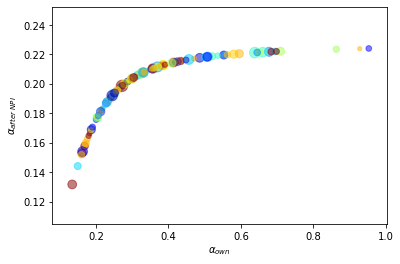

In [8]:
alpha_equal = g(g_inv(alpha_predicted) + 10000)
scatter_plot(alpha_equal)

We can see when we have an equal distribution of non-pharmaceutical interventions, it appears that NPI has a bigger effect on the larger $\alpha$ values than the smaller ones. It seems the relationship between $\alpha_{own}$ and $\alpha_{after\ NPI}$ seems to be logarithmic. It also seems the equal distribution of funds makes is so some very small populations have large decreases in the $\alpha$ value, while the bigger populations do not.

ii.

In [9]:
total_recovered = total_recovered_difference(alpha_equal)
print(f'The Difference in the Number of people who succumbed to the virus after 200 days when using equal NPI funding is approximately {int(round(total_recovered))}')


The Difference in the Number of people who succumbed to the virus after 200 days when using equal NPI funding is approximately 320440


### Policy #2

i. 

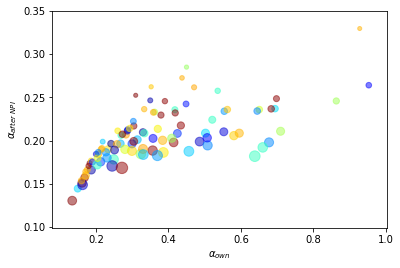

In [10]:
population_prop = N/np.sum(N)
money_allocation = population_prop*1000000
alpha_prop = g(g_inv(alpha_predicted) + money_allocation)
scatter_plot(alpha_prop)

As we can see from this plot, there is still a semi-logarithmic distribution of the points. As we can also see, many of the bigger population nodes seem to have had a greater decrease in the $\alpha$ value than the smaller nodes. this would make sense, as we would try and put more money to stop it from spreading faster in these areas. Because there is more weight put on these bigger populations, out scatterplot shows to be more flat then if we provide equal funding. 

ii.

In [60]:
total_recovered = total_recovered_difference(alpha_prop)
print(f'The Difference in the Number of people who succumbed to the virus after 200 days when using equal NPI funding is approximately {int(round(total_recovered))}')


The Difference in the Number of people who succumbed to the virus after 200 days when using equal NPI funding is approximately 335994


### Policy #3

i.

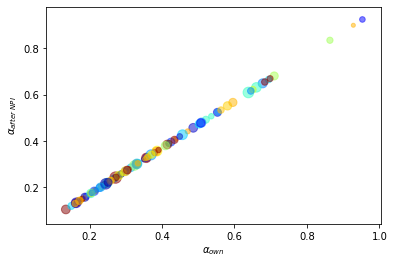

In [108]:
def delta_a(alpha):
    
    ###### WRITE YOUR FUNCTION HERE

    '''
    check the value below I'm not sure how to calculate it
    ''' 
    alpha_after = alpha_predicted-alpha
    money_total = g_inv(alpha_after)-g_inv(alpha_predicted)
    dif = abs(1000000 - sum(money_total))
    
  

    return dif


change_a = fmin(delta_a, 0.1, disp=False)
scatter_plot((alpha_predicted-change_a))

In [109]:
print((alpha_predicted-change_a))

[0.20411617 0.35659954 0.19799282 0.68035061 0.64847805 0.17743923
 0.3281625  0.32717067 0.35006191 0.1576791  0.25343105 0.30025722
 0.28480312 0.18682644 0.10496761 0.2121957  0.17091152 0.52355434
 0.55136501 0.15280849 0.24007656 0.27497036 0.45676357 0.2802621
 0.30414821 0.1391122  0.34019863 0.18468105 0.44150478 0.63109981
 0.26998378 0.27380459 0.35453121 0.14671718 0.5662698  0.60907985
 0.36092617 0.14145595 0.25859462 0.83416835 0.38505336 0.40815517
 0.3953561  0.15662929 0.21953518 0.40500576 0.6649789  0.29441616
 0.21523525 0.18918544 0.1201913  0.18343593 0.30047695 0.23817226
 0.15020839 0.62151882 0.16085292 0.49167873 0.24229366 0.52482692
 0.33266689 0.25721523 0.32042324 0.38846828 0.23051235 0.47890102
 0.17389919 0.38935634 0.42707302 0.13218242 0.13363125 0.30133754
 0.26364834 0.42055751 0.3798196  0.26989223 0.5333871  0.61574489
 0.34131252 0.17479335 0.30372707 0.47298977 0.66895229 0.32903835
 0.25064937 0.27482235 0.24361049 0.5066415  0.92386562 0.47764

ii.

In [110]:
total_recovered = total_recovered_difference(alpha_predicted-change_a)
print(f'The Difference in the Number of people who succumbed to the virus after 200 days when using equal change in alpha is approximately {int(round(total_recovered))}')


The Difference in the Number of people who succumbed to the virus after 200 days when using equal change in alpha is approximately 62743


### Policy #4

i.

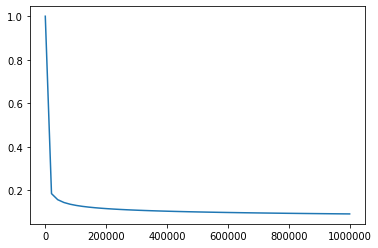

In [126]:
x = np.linspace(0,1000000)
plt.plot(x, g(x)) 


As you see above the maximum change per dollar is when alpha is at its greatest. Therefore in order to maximize the change per cent, it would be best to find the greatest alpha value for every cent and give that node the cent. We do not go below a cent because legally one cent is the minimum amount that can be spent

In [138]:
#maximize the minimization of alpha per dollar
#in order to find the maximum change in alpha we need to find the maximum alpha values
#
import operator
alpha_news = alpha_predicted
for i in range (100000000):
    index = np.argmax(alpha_news)
    value = alpha_news[index]
    alpha_news[index] = g(g_inv(value)+.01)

C:\Users\Romtin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


ii.

In [140]:
total_recovered = total_recovered_difference(alpha_news)
print(f'The Difference in the Number of people who succumbed to the virus after 200 days when maximizing change in alpha per cent is approximately {int(round(total_recovered))}')


The Difference in the Number of people who succumbed to the virus after 200 days when maximizing change in alpha per cent is approximately 583792


## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4